In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

In [2]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [ ]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

In [4]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [ ]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

In [6]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
    
df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

In [ ]:
#pca
from local_utils import *

pca_cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})
df_pd = add_pca_columns(df_pd,  pca_cols,  n_components = 2)

In [ ]:
#knn
knn_cols = ['days_since_first_order', 'days_since_last_order', 'sum_discount_price_to_cart', 'num_products_click', 'main_search_cluster', 'search_cluster_stability', 'product_cluster_stability']

df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=5, use_gpu=True)

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

In [ ]:
#catboost
from local_utils import *

# Подготовка данных (аналогично вашему коду)
df_pd = df_pd[df_pd['user_id'] != 2346229]

tr, val = get_split(df_pd, val_size=0.25, random_state=42)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

# Параметры CatBoost (аналогичные вашим LGBM параметрам)
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.01,
    'depth': 10,  # Аналог max_depth в LGBM
    'iterations': 900,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'random_seed': 42,
    'thread_count': -1,  # Использовать все ядра
    'grow_policy': 'Lossguide', # Более быстрый режим роста
}

catboost_model = train_catboost_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

0:	test: 0.7395082	best: 0.7395082 (0)	total: 494ms	remaining: 7m 23s
100:	test: 0.7515158	best: 0.7516247 (88)	total: 37.3s	remaining: 4m 55s
200:	test: 0.7556759	best: 0.7556774 (198)	total: 1m 17s	remaining: 4m 28s
300:	test: 0.7577553	best: 0.7577553 (300)	total: 1m 59s	remaining: 3m 58s
400:	test: 0.7584496	best: 0.7584562 (399)	total: 2m 45s	remaining: 3m 25s
500:	test: 0.7589790	best: 0.7589790 (500)	total: 3m 34s	remaining: 2m 50s
600:	test: 0.7594354	best: 0.7594354 (600)	total: 4m 25s	remaining: 2m 12s
700:	test: 0.7597388	best: 0.7597388 (700)	total: 5m 18s	remaining: 1m 30s
800:	test: 0.7599390	best: 0.7599401 (796)	total: 6m 11s	remaining: 45.9s
899:	test: 0.7600725	best: 0.7600765 (898)	total: 7m 3s	remaining: 0us

bestTest = 0.760076505
bestIteration = 898

Shrink model to first 899 iterations.


feature_importance: [4.61757143e-01 1.30103527e-01 1.01665932e-01 3.53145728e+00
 1.52988438e+00 6.64802490e-03 1.14435181e-01 1.71137832e-02
 5.78036485e-02 4.46850693e-03 3.36369843e-02 3.67233412e-02
 4.73426157e-01 1.41356966e-01 7.46874040e-03 1.17461300e-01
 3.86030790e-01 1.06401361e-01 2.54839570e-02 6.10362584e-03
 9.69382897e-02 1.66994318e+00 1.09461238e-01 8.23821191e-02
 2.16368181e-02 3.79146808e-02 4.87246265e-01 6.46731317e-01
 1.50307346e+00 1.64757769e-01 1.06259993e-01 8.13513529e-03
 3.97885983e-03 5.25417590e-01 4.30299280e-02 1.85829678e-01
 7.35785407e-01 1.13365868e-02 9.30103134e-03 9.00760530e-03
 4.46052814e-02 3.92718470e-02 2.81726331e-01 5.81965160e-02
 2.24474905e-02 1.45218800e-02 1.73797550e-02 3.06504931e-03
 5.19981606e-03 6.22799772e-02 7.52947902e-02 3.87762995e-01
 1.37590904e-02 7.27927576e-01 1.08424695e-01 1.95550639e-01
 5.06372702e-02 3.86009231e-03 8.17593217e-03 1.49955862e-01
 7.01284555e-03 8.57558302e-02 4.52124689e-01 1.50247581e+01
 8.2

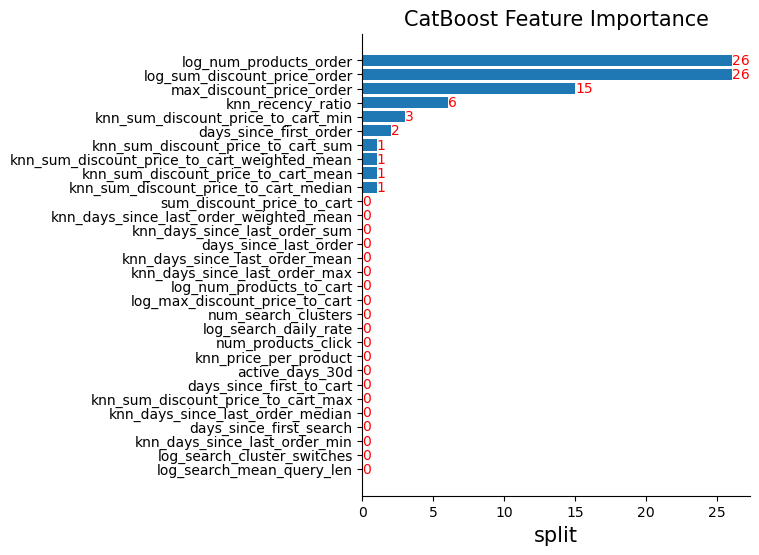

In [10]:
from local_utils import *

print('feature_importance:', catboost_model.feature_importances_, '\n')

plot_catboost_importance(catboost_model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

In [ ]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

In [ ]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

In [15]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [ ]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

In [17]:
from local_utils import *

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')

test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [ ]:
test_df_pd = add_pca_columns(test_df_pd,  pca_cols,  n_components = 2)

In [ ]:
test_df_pd = add_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=5, use_gpu=True)

In [ ]:
def add_time_pattern_features(df_pd, actions_history, product_info):
    # Конвертируем product_info в LazyFrame если нужно
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    time_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            ((pl.col('timestamp').dt.hour() >= 6) & (pl.col('timestamp').dt.hour() < 12)).alias('new_is_morning'),
            ((pl.col('timestamp').dt.hour() >= 12) & (pl.col('timestamp').dt.hour() < 18)).alias('new_is_day'),
            (pl.col('timestamp').dt.weekday() >= 5).alias('new_is_weekend'),
            (pl.col('timestamp').dt.hour()).alias('new_hour'),
            (pl.col('timestamp').dt.weekday()).alias('new_dow')
        ])
        .join(
            product_info_lazy.select(['product_id', 'discount_price']), 
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
            (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
            (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
            pl.col('new_hour').value_counts().struct.field('count').entropy().alias('new_hour_entropy'),
            (pl.col('new_dow').filter(pl.col('new_dow') < 5).count() / 
             (pl.col('new_dow').filter(pl.col('new_dow') >= 5).count() + 1e-6)).alias('new_weekday_weekend_ratio'),
            (pl.col('discount_price').filter(pl.col('new_is_morning')).sum() / 
            (pl.col('new_is_morning').sum() + 1e-6)).alias('new_morning_avg_spend')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(time_aggs, on='user_id', how='left')

In [86]:
def add_brand_category_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    brand_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .join(
            product_info_lazy.select(['product_id', 'brand', 'category_id', 'discount_price']),
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            pl.col('brand').n_unique().alias('new_unique_brands'),
            (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
            pl.col('category_id').n_unique().alias('new_unique_categories'),
            pl.col('category_id').value_counts().struct.field('count').max().alias('new_favorite_category_count'),
            (pl.col('discount_price').filter(pl.col('category_id') == 
             pl.col('category_id').mode().first()).mean()).alias('new_main_category_avg_price')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(brand_aggs, on='user_id', how='left')

In [87]:
def add_search_features(df_pd, search_history):
    search_aggs = (
        search_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            pl.col('search_query').str.split(' ').list.len().alias('new_query_word_count'),  # Исправлено здесь
            pl.col('search_query').str.contains(r'\d').alias('new_has_numbers')
        ])
        .group_by('user_id')
        .agg(
            pl.mean('new_query_word_count').alias('new_avg_query_length'),
            (pl.sum('new_has_numbers') / pl.count()).alias('new_numeric_query_ratio'),
            pl.col('search_query').filter(pl.col('search_query').str.len_chars() > 20).count().alias('new_long_queries_count')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(search_aggs, on='user_id', how='left')

In [ ]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

# Добавляем новые признаки
add_new_df_pd = add_time_pattern_features(df_pd, actions_history, product_info)
add_new_df_pd = add_brand_category_features(add_new_df_pd, actions_history, product_info) 
add_new_df_pd = add_search_features(add_new_df_pd, search_history)

add_new_df_pd

In [ ]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

# Добавляем новые признаки
add_new_test_df_pd = add_time_pattern_features(test_df_pd, actions_history, product_info)
add_new_test_df_pd = add_brand_category_features(add_new_test_df_pd, actions_history, product_info) 
add_new_test_df_pd = add_search_features(add_new_test_df_pd, search_history)

add_new_test_df_pd

In [ ]:
from local_utils import *

add_new_df_pd = add_new_df_pd[add_new_df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(add_new_df_pd, val_size=0.20, random_state=50)

add_new_cols = list(set(add_new_df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.0075,
    
    'max_depth': 75,
    'num_leaves': 75,
    'min_data_in_leaf': 30,
    
    # Настройки обучения
    'num_iterations': 1000,
    'early_stopping_rounds': 60,
    'seed': 42,
    
    # Дополнительно
    'importance_type': 'split',
}

lgb_model = train_model_new(lgb_tr, lgb_val, add_new_cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)


Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.759044	valid's auc: 0.757658
[200]	train's auc: 0.760088	valid's auc: 0.758579
[300]	train's auc: 0.760933	valid's auc: 0.759115
[400]	train's auc: 0.761795	valid's auc: 0.75964
[500]	train's auc: 0.762474	valid's auc: 0.760225
[600]	train's auc: 0.763049	valid's auc: 0.760406
[700]	train's auc: 0.763551	valid's auc: 0.760656
[800]	train's auc: 0.764009	valid's auc: 0.760781
[900]	train's auc: 0.764396	valid's auc: 0.760831
[1000]	train's auc: 0.764803	valid's auc: 0.760888
Did not meet early stopping. Best iteration is:
[998]	train's auc: 0.764798	valid's auc: 0.760888


feature_importance: [ 651  742  192 1001  313  209  617  207  192  243  588  572  497 1209
  359   58 1205 1577  333  649  130  432  486  952  822  248   49  259
 1633  204  250  615  372  189  192  518  334  423  392 1106  534  158
   78  454  554   54 1052  110  263  499    0  195    6  615  746 1594
  202   29  741  472  506  659   25   11  621  388  245  606 1529 1408
  364    9    6  760  209  385 2194  913  108 2913 1323 1072  346  416
  938  516  103  150    0  917 1199  828 1704  109  278  114  568    0
  907  204  515  151  827   47 1498 2851  200  647 1226  147  114  140
  242   31  564  157 1358   33   80    0  211  112  294  502  129  758
  221 1771    0  182  341  419  602  202  349   63 1350  591] 



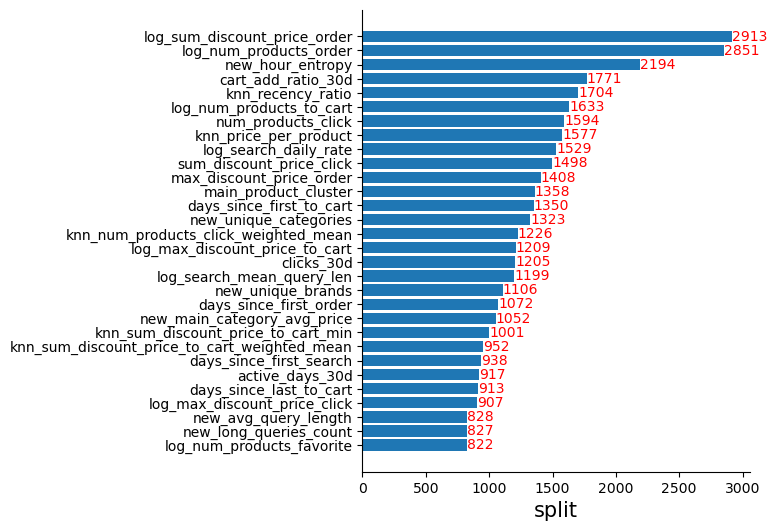

In [113]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, add_new_cols, importance_type='split', top_k=30, sklearn_style=True)

#res = list_lgbm_importance(lgb_model, cols, sklearn_style=True, top_k=30)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [101]:
from local_utils import *

# Подготовка данных (аналогично вашему коду)
add_new_df_pd = add_new_df_pd[add_new_df_pd['user_id'] != 2346229]

tr, val = get_split(add_new_df_pd, val_size=0.30, random_state=45)

cols = list(set(add_new_df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

# Параметры CatBoost (аналогичные вашим LGBM параметрам)
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.01,
    'depth': 10,  # Аналог max_depth в LGBM
    'iterations': 900,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'random_seed': 42,
    'thread_count': -1,  # Использовать все ядра
    'grow_policy': 'Lossguide', # Более быстрый режим роста
}

catboost_model = train_catboost_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

0:	test: 0.7451386	best: 0.7451386 (0)	total: 430ms	remaining: 6m 26s
100:	test: 0.7511743	best: 0.7511743 (100)	total: 40.1s	remaining: 5m 17s
200:	test: 0.7565556	best: 0.7565564 (199)	total: 1m 22s	remaining: 4m 45s
300:	test: 0.7584692	best: 0.7584738 (296)	total: 2m 6s	remaining: 4m 11s
400:	test: 0.7593404	best: 0.7593494 (395)	total: 2m 52s	remaining: 3m 34s
500:	test: 0.7598254	best: 0.7598257 (498)	total: 3m 43s	remaining: 2m 58s
600:	test: 0.7601222	best: 0.7601223 (599)	total: 4m 39s	remaining: 2m 19s
700:	test: 0.7605622	best: 0.7605622 (700)	total: 5m 36s	remaining: 1m 35s
800:	test: 0.7608445	best: 0.7608445 (800)	total: 6m 33s	remaining: 48.6s
899:	test: 0.7610529	best: 0.7610529 (899)	total: 7m 29s	remaining: 0us

bestTest = 0.7610528708
bestIteration = 899



feature_importance: [3.98681678e-01 1.64519535e-01 8.39082424e-02 3.87742943e+00
 1.49042359e+00 7.00775499e-03 1.10833495e-01 1.11464481e-02
 3.98021627e-02 5.27217603e-03 7.89296922e-03 7.56514322e-02
 2.88137747e-02 6.06341459e-01 8.95386289e-02 6.13128908e-03
 9.21194004e-02 3.49312691e-01 8.28358816e-02 5.27911334e-02
 2.08905794e-03 5.37984137e-02 5.01952638e-03 1.10559749e+00
 9.40831354e-02 9.31775203e-02 1.16721095e-02 4.11652675e-02
 5.21650284e-01 5.93855738e-01 1.91996379e+00 7.86991474e-02
 6.96505564e-02 9.05674703e-03 5.26416108e-02 4.49169729e-01
 4.05875949e-02 1.37076143e-01 5.80967988e-01 1.26431830e-01
 1.27618872e-02 2.27912314e-02 8.81801450e-03 2.87646183e-02
 4.49241681e-02 5.60656478e-01 5.05530519e-02 7.85476297e-02
 1.63479398e-02 1.26227665e-02 1.23791410e-02 2.62965528e-03
 2.22681214e-03 5.89555442e-02 7.29240416e-02 3.15204068e-01
 1.16716772e-02 4.90446699e-01 4.41603683e-02 1.22596720e-01
 1.29324634e-01 5.35618000e-02 2.20903628e-02 9.98023017e-03
 8.0

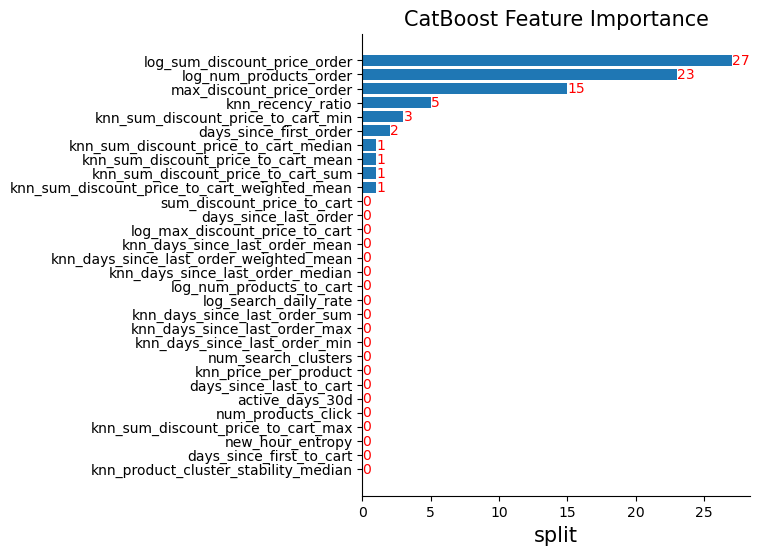

In [102]:
from local_utils import *

print('feature_importance:', catboost_model.feature_importances_, '\n')

plot_catboost_importance(catboost_model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [114]:
add_new_test_df_pd['catboost_predict'] = catboost_model.predict_proba(add_new_test_df_pd[cols])[:, 1]
add_new_test_df_pd['lgb_predict'] = lgb_model.predict_proba(add_new_test_df_pd[cols])[:, 1]

In [115]:
add_new_test_df_pd['predict'] = add_new_test_df_pd[['catboost_predict', 'lgb_predict']].mean(axis=1)

In [116]:
add_new_test_df_pd[['user_id', 'catboost_predict', 'lgb_predict', 'predict']]

,user_id,catboost_predict,lgb_predict,predict
0,1342,0.167752,0.179570,0.173661
1,9852,0.753778,0.829726,0.791752
2,10206,0.215888,0.214007,0.214947
3,11317,0.224816,0.231326,0.228071
4,13289,0.607850,0.611156,0.609503
...,...,...,...,...
2068419,11157283,0.203795,0.195736,0.199765
2068420,11160395,0.154657,0.122811,0.138734
2068421,11165052,0.624003,0.604319,0.614161
2068422,11168218,0.543258,0.522588,0.532923


In [117]:
add_new_test_df_pd[['user_id', 'predict']].to_csv('new_fe_8244_1.csv', index=False)

In [20]:
test_df_pd['catboost_predict'] = catboost_model.predict_proba(test_df_pd[cols])[:, 1]
test_df_pd['lgb_predict'] = lgb_model.predict_proba(test_df_pd[cols])[:, 1]

#test_df_pd['predict'] = model.predict(test_df_pd[cols])

In [21]:
test_df_pd['predict'] = test_df_pd[['catboost_predict', 'lgb_predict']].mean(axis=1)

In [22]:
test_df_pd[['user_id', 'catboost_predict', 'lgb_predict', 'predict']]

,user_id,catboost_predict,lgb_predict,predict
0,1342,0.160576,0.172984,0.166780
1,9852,0.750933,0.808319,0.779626
2,10206,0.214917,0.221423,0.218170
3,11317,0.214947,0.228265,0.221606
4,13289,0.604772,0.598704,0.601738
...,...,...,...,...
2068419,11157283,0.197924,0.200426,0.199175
2068420,11160395,0.163636,0.144137,0.153886
2068421,11165052,0.613123,0.631671,0.622397
2068422,11168218,0.555000,0.526293,0.540646


In [23]:
test_df_pd[['user_id', 'predict']].to_csv('full_ensemble_cat_and_lgb_mean.csv', index=False)